In [ ]:
#Create pretty maps for street view project following 
#http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Vx2fYZMrKL_

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from itertools import chain
from descartes import PolygonPatch
from pysal.esda.mapclassify import Natural_Breaks as nb
from shapely.geometry import Polygon
import fiona
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from lxml import etree
import csv
import os
import locale
from matplotlib import gridspec
%matplotlib inline

In [2]:
# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, discretize, labels=None, max_label=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    if discretize:
        cmap = cmap_discretize(cmap, ncolors)
        max_label=ncolors;
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, max_label+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, int(max_label), ncolors))
    colorbar.set_ticklabels(np.linspace(0,int(max_label),ncolors))
    colorbar.ax.tick_params(labelsize=20) 
    colorbar.ax.tick_params(color='#808080')
    colorbar.outline.set_linewidth(2)
    colorbar.outline.set_edgecolor('#808080')
    if labels:
        colorbar.set_ticklabels(labels)


    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

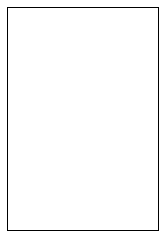

In [32]:
'''
#First try for Chicago with another shapefile
extra=0.02#0.01
shp=fiona.open('data/chicago.shp')
bds=shp.bounds
ll=(bds[0],bds[1])
ur=(bds[2],bds[3])
coords=list(chain(ll,ur))
w,h=coords[2]-coords[0],coords[3]-coords[1]

m = Basemap(
    projection='tmerc',
    lon_0=-87.,
    lat_0=41.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] + 10*extra *w,
    llcrnrlat=coords[1] + 3*(extra + 0.01 * h),
    urcrnrlon=coords[2] - extra * w,
    urcrnrlat=coords[3] - 3*(extra - 0.01 * h),
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'data/chicago',
    'chicago',
    drawbounds=False,
    color='none',
    zorder=2)

# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.chicago],
    'zipcode': [zipcode['zip'] for zipcode in m.chicago_info]})
'''
shp=fiona.open('data/cb_2013_us_zcta510_500k.shp')
shp.close()
city_bounds=np.loadtxt('/afs/cs.stanford.edu/u/tgebru/cars/ipython_code/data/cityids_bounds.txt',
                      delimiter=',')
#Birmingham 33.678715 South Latitude: 33.383760 East Longitude: -86.578150 West Longitude: -87.122124
#ll=(-87.122124,33.383760)
#ur=(-86.578150,33.678715)
#lon_0=-86.85013699999999,
#lat_0=33.5312375,

#for city in xrange(city_bounds.size):
city=8
cityid=int(city_bounds[city,0])
ll=(city_bounds[city,4],city_bounds[city,2])
ur=(city_bounds[city,3],city_bounds[city,1])
coords=list(chain(ll,ur))
w,h=coords[2]-coords[0],coords[3]-coords[1]
extra=0.05
#The center lat, longs for the city
lon_0=0.5*(city_bounds[city,3]+city_bounds[city,4])
lat_0=0.5*(city_bounds[city,1]+city_bounds[city,2])
m = Basemap(
    projection='tmerc',
    lon_0=lon_0,
    lat_0=lat_0,
    lat_ts=0,
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra * h,
    ellps = 'WGS84',
    resolution='c',
    suppress_ticks=True)

m.readshapefile(
    'data/cb_2013_us_zcta510_500k',
    'us',
    color='none',
    zorder=2)

# set up a map dataframe
all_df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.us],
    'zipcode': [zipcode['ZCTA5CE10'] for zipcode in m.us_info]})

In [13]:
llcrnrlon=coords[0] + 10*extra *w
llcrnrlat=coords[1] + 3*(extra + 0.01 * h)
urcrnrlon=coords[2] - extra * w
urcrnrlat=coords[3] - 3*(extra - 0.01 * h)
llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,coords,

(-71.057157000000004,
 42.383009610000002,
 -70.936596600000001,
 42.253996610000002,
 [-71.191113000000001,
  42.227879999999999,
  -70.923201000000006,
  42.398867000000003])

In [33]:
#Get income values for each zipcode
zip_income_dict={}
info_dir='/scail/scratch/u/tgebru/gsv_classify/analysis/demo/results/predictions'
info_file='unfiltered.Median_household_income_--total.ZIPCODE.glm.0.no.5.ni.1.rc.1.minp.10000.minc.1000.cp.1.train-20.whole_country.0.prev.1.manhat.0.txt'
lines=open(os.path.join(info_dir,info_file),'rb').readlines()
for l in lines:
  zipcode=l.split(',')[0].strip()
  if len(zipcode) is not 5:
        zipcode='0%s'%zipcode
  if 'zipcode' in zip_income_dict:
      zip_income_dict['zipcode'].append(zipcode)
  else: 
      zip_income_dict['zipcode']=[zipcode]
  if 'actual' in zip_income_dict:
      zip_income_dict['actual'].append(float(l.split(',')[1].strip()))
  else:
      zip_income_dict['actual'] = [float(l.split(',')[1].strip())]
  if 'predicted' in zip_income_dict:
      zip_income_dict['predicted'].append(float(l.split(',')[2].strip()))

  else:
      zip_income_dict['predicted']=[float(l.split(',')[2].strip())]

income=pd.DataFrame(zip_income_dict)
all_df_map = all_df_map.merge(income)

#Get zipcodes for each of the 200 cities and map boundaries
city_zips=np.loadtxt('/scail/scratch/u/tgebru/gsv_classify/analysis/demo/files/zip_new.txt',
                     delimiter='\t')
cityids=np.unique(city_zips[:,1])
cur_zip_inds=np.where(city_zips[:,1]==cityid)
cur_zips=city_zips[cur_zip_inds[0],0]
#if there is a leading zero in the zipcode it will be ignored so add it 
form_zips=[]
for zipcode in cur_zips:
    if len(zipcode.astype(int).astype(str)) is not 5:
        form_zip='0%s'%zipcode.astype(int).astype(str)
    else:
        form_zip=zipcode.astype(int).astype(str)
    form_zips.append(form_zip)

df_cur_zip = pd.DataFrame({'zipcode': form_zips})
df_map = all_df_map.merge(df_cur_zip)

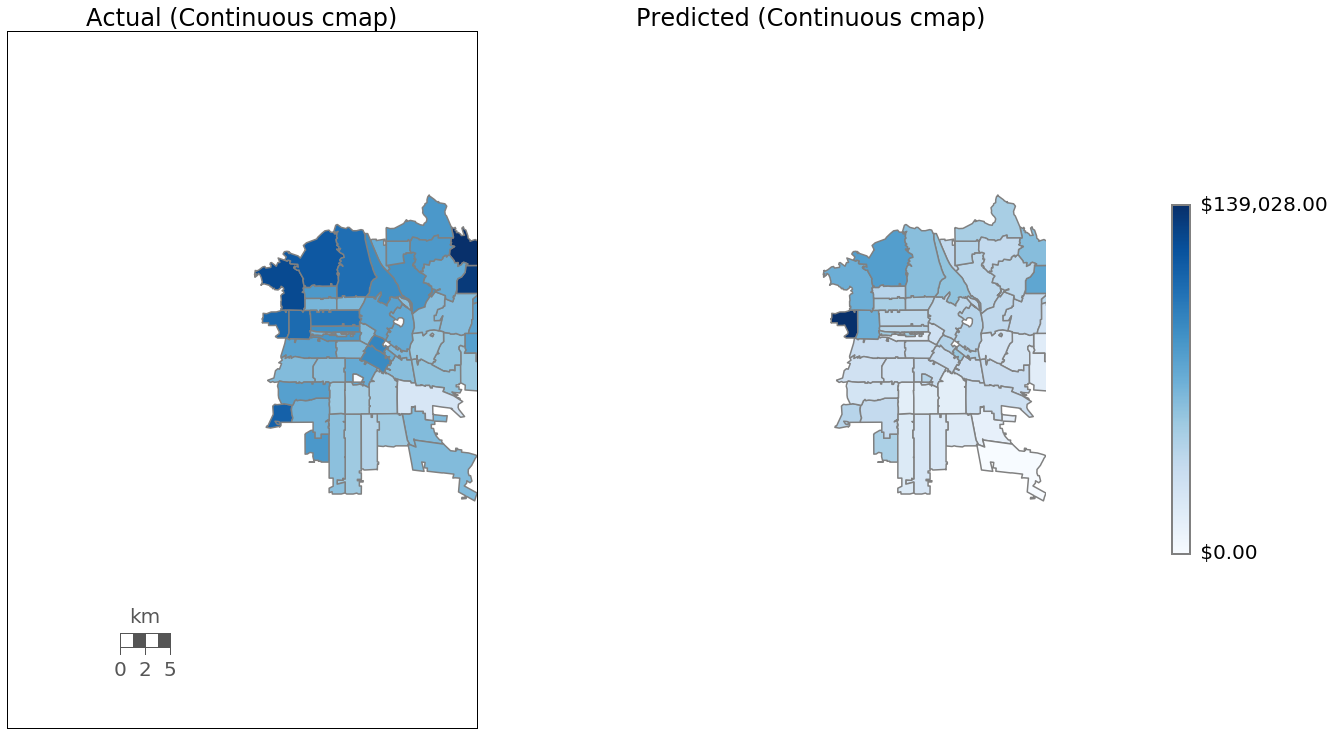

In [35]:
#Make Actual/Predicted maps with continuous colormap: no binning
plt.clf()
fig = plt.figure(figsize=(30, 10))
fig.set_size_inches(20, 10)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.245]) 
ax1 = fig.add_subplot(gs[0], axisbg='w', frame_on=False)

#Actual Map
# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')

# draw zipcodes with grey outlines
df_map['patches_act'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=1.5, alpha=1, zorder=4))   

pc = PatchCollection(df_map['patches_act'], match_original=True)
# impose our color map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['actual'].values)))
ax1.add_collection(pc)
plt.title("Actual (Continuous cmap)",fontsize=24)

m.drawmapscale(
    coords[0] + 0.15, coords[1] + 0.08,
    coords[0], coords[1],
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w',fillcolor2='#555555',
    fontcolor='#555555',
    fontsize=20,
    zorder=5)

m.drawmapboundary(linewidth=1)

#Predicted Map   
ax2 = fig.add_subplot(gs[1], axisbg='w', frame_on=False)
df_map['patches_pred'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=1.5, alpha=1, zorder=4))   
pc2 = PatchCollection(df_map['patches_pred'], match_original=True)
norm = Normalize()
pc2.set_facecolor(cmap(norm(df_map['predicted'].values)))
ax2.add_collection(pc2)

# Add a colour bar
locale.setlocale( locale.LC_ALL, '' )
max_label=max(df_map['actual'].values) 
ncolors=2
labels = [" %s" % locale.currency(n, grouping=True) for n in 
          np.linspace(0,int(max_label),ncolors)]

cb = colorbar_index(ncolors=ncolors, labels=labels, discretize=False, 
                    cmap=cmap, max_label=max_label, shrink=0.5)
plt.title("Predicted (Continuous cmap) %d"%cityid,fontsize=24)
m.drawmapboundary(linewidth=0)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

In [1335]:
# Calculate Jenks natural breaks for Median Household Income
breaks = nb(
    df_map[df_map['actual'].notnull()].actual.values,
    initial=300,
    k=7)
jb_act = pd.DataFrame({'actual_jenks_bins': breaks.yb}, index=df_map[df_map['zipcode'].notnull()].index)

#Calculate the predicted bin number for each zipcode
pred_bins_dict={'zipcode':[],'pred_jenks_bins':[]}

breaks_list=list(breaks.bins)
for zipcode, pred in zip(df_map.zipcode, df_map.predicted):
        pred_bins_dict['zipcode'].append(zipcode)
        i=0
        for bin_val,bin_num in zip(breaks_list, range(len(breaks.bins))):
            if pred <= breaks_list[0]:
                pred_bins_dict['pred_jenks_bins'].append(0)
                break;
            if pred>bin_val and pred <=breaks_list[i+1]:
                pred_bins_dict['pred_jenks_bins'].append(bin_num)
                break;
            i += 1 
            
df_map = df_map.join(jb_act)
df_map=df_map.merge(pd.DataFrame(pred_bins_dict))

df_map.actual_jenks_bins.fillna(-1, inplace=True) 
df_map.pred_jenks_bins.fillna(-1, inplace=True) 

#We also want to create a sensible label for our classes:
#jenks_labels = ["<= $%0.1f(%s Zipcodes)" % (b, c) for b, c in zip(
#    breaks.bins, breaks.counts)]
locale.setlocale( locale.LC_ALL, '' )
jenks_labels = [" <= %s" % locale.currency(b, grouping=True) for b in breaks.bins]
#jenks_labels.insert(0, 'No data (%f Zipcodes)' % len(df_map[df_map['actual'].isnull()]))

IndexError: list index out of range

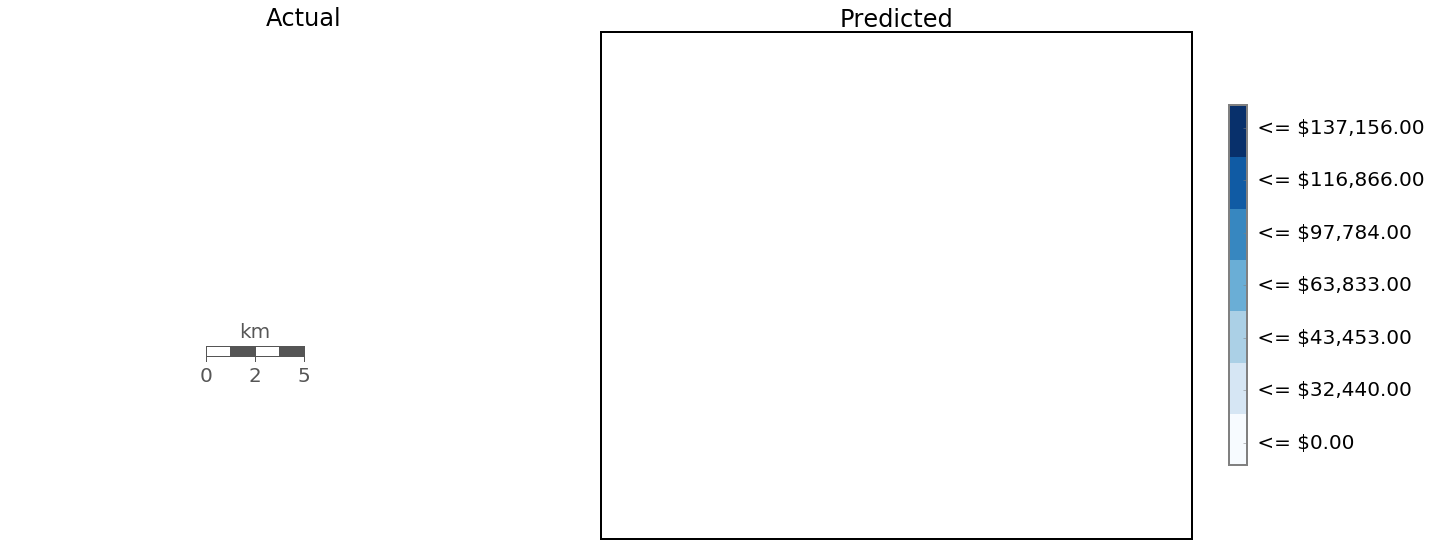

In [1325]:
plt.clf()
fig = plt.figure(figsize=(20, 10))
#fig.set_size_inches(20, 10)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.245]) 
ax1 = fig.add_subplot(gs[0], axisbg='w', frame_on=False)

#Actual Map
# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')

# draw zipcodes with grey outlines
df_map['patches_act'] = df_map['poly'].map(lambda x: 
                        PolygonPatch(x, ec='#808080', lw=0.5, alpha=1., zorder=4))   

pc = PatchCollection(df_map['patches_act'], match_original=True)
# impose our color map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['actual_jenks_bins'].values)))
ax1.add_collection(pc)


m.drawmapscale(
    coords[0] + 0.15, coords[1] + 0.08,
    coords[0], coords[1],
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w',fillcolor2='#555555',
    fontcolor='#555555',
    fontsize=20,
    zorder=5)

m.drawmapboundary(linewidth=0)

# this will set the image width to 722px at 100dpi
plt.title("Actual",fontsize=24)

#Predicted Map   
ax2 = fig.add_subplot(gs[1], axisbg='w', frame_on=False)
df_map['patches_pred'] = df_map['poly'].map(lambda x: 
                            PolygonPatch(x, ec='#808080', lw=0.5, alpha=1., zorder=4))   
pc2 = PatchCollection(df_map['patches_pred'], match_original=True)
norm = Normalize()
pc2.set_facecolor(cmap(norm(df_map['pred_jenks_bins'].values)))
ax2.add_collection(pc2)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), discretize=True,
                    cmap=cmap, shrink=0.5, labels=jenks_labels)
#cb.ax.tick_params(labelsize=6)

m.drawmapboundary(linewidth=2)

# this will set the image width to 722px at 100dpi
plt.title("Predicted",fontsize=24)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('data/chicago_income.png', dpi=100, alpha=True)
plt.show()

In [1326]:
df_map['patches_pred']

0     Poly((3.41638e+06, -694389) ...)
1     Poly((3.42741e+06, -688099) ...)
2     Poly((3.41758e+06, -685352) ...)
3     Poly((3.42195e+06, -685709) ...)
4     Poly((3.41236e+06, -695895) ...)
5     Poly((3.43175e+06, -693423) ...)
6     Poly((3.43065e+06, -678993) ...)
7     Poly((3.42757e+06, -675194) ...)
8     Poly((3.42287e+06, -691984) ...)
9     Poly((3.42287e+06, -691984) ...)
10    Poly((3.42752e+06, -688166) ...)
11    Poly((3.42752e+06, -688166) ...)
12    Poly((3.42449e+06, -677343) ...)
13    Poly((3.42134e+06, -666176) ...)
14    Poly((3.41954e+06, -669764) ...)
15     Poly((3.4143e+06, -688300) ...)
16    Poly((3.42296e+06, -684872) ...)
17    Poly((3.42671e+06, -684084) ...)
18    Poly((3.42076e+06, -680907) ...)
19    Poly((3.43106e+06, -669940) ...)
20    Poly((3.42436e+06, -680388) ...)
21    Poly((3.42054e+06, -700949) ...)
22    Poly((3.41666e+06, -685306) ...)
23    Poly((3.40425e+06, -689766) ...)
24    Poly((3.41675e+06, -701636) ...)
25    Poly((3.41675e+06, 

In [1199]:
#Plot ranks as opposed to absolute values
#Rank zipcodes
df_map['actual_rank']=df_map['actual'].rank(ascending=0)
df_map['predicted_rank']=df_map['predicted'].rank(ascending=0)
# Calculate Jenks natural breaks for Median Household Income
breaks = nb(
    df_map[df_map['actual_rank'].notnull()].actual_rank.values,
    initial=300,
    k=7)
jb_act = pd.DataFrame({'actual_rank_bins': breaks.yb}, index=df_map[df_map['zipcode'].notnull()].index)

#Calculate the predicted bin number for each zipcode
pred_breaks = nb(
    df_map[df_map['predicted_rank'].notnull()].predicted_rank.values,
    initial=300,
    k=7)
jb_pred = pd.DataFrame({'pred_rank_bins': pred_breaks.yb}, index=df_map[df_map['zipcode'].notnull()].index)

            
df_map = df_map.join(jb_act)
df_map = df_map.join(jb_pred)

df_map.actual_jenks_bins.fillna(-1, inplace=True) 
df_map.pred_jenks_bins.fillna(-1, inplace=True) 

#We also want to create a sensible label for our classes:
#jenks_labels = ["<= $%0.1f(%s Zipcodes)" % (b, c) for b, c in zip(
#    breaks.bins, breaks.counts)]
rank_labels = [" <= %s" % b for b in breaks.bins]

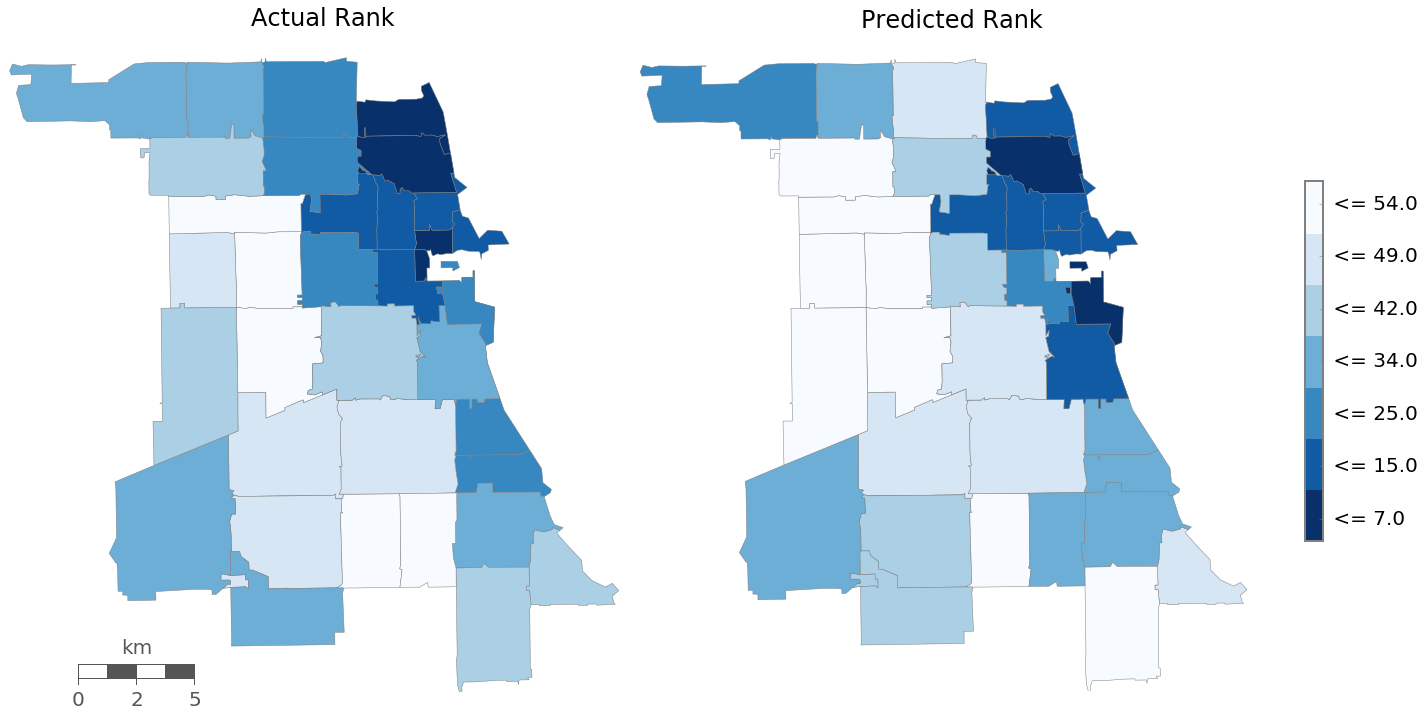

In [1200]:
#Make maps
plt.clf()
fig = plt.figure(figsize=(20, 10))
#fig.set_size_inches(20, 10)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.245]) 
ax1 = fig.add_subplot(gs[0], axisbg='w', frame_on=False)

#Actual Map
# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues_r')

# draw zipcodes with grey outlines
df_map['patches_act'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=0.5, alpha=1., zorder=4))   

pc = PatchCollection(df_map['patches_act'], match_original=True)
# impose our color map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['actual_rank_bins'].values)))
ax1.add_collection(pc)

m.drawmapscale(
    coords[0] + 0.15, coords[1] + 0.08,
    coords[0], coords[1],
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w',fillcolor2='#555555',
    fontcolor='#555555',
    fontsize=20,
    zorder=5)

m.drawmapboundary(linewidth=0)

# this will set the image width to 722px at 100dpi
plt.title("Actual Rank",fontsize=24)

#Predicted Map   
ax2 = fig.add_subplot(gs[1], axisbg='w', frame_on=False)
df_map['patches_pred'] = df_map['poly'].map(lambda x: 
                                       PolygonPatch(x, ec='#808080', lw=0.5, alpha=1., zorder=4))   
pc2 = PatchCollection(df_map['patches_pred'], match_original=True)
norm = Normalize()
pc2.set_facecolor(cmap(norm(df_map['pred_rank_bins'].values)))
ax2.add_collection(pc2)

# Add a colour bar
cb = colorbar_index(ncolors=len(rank_labels), discretize=True, cmap=cmap, shrink=0.5, labels=rank_labels)
#cb.ax.tick_params(labelsize=6)

m.drawmapboundary(linewidth=0)

# this will set the image width to 722px at 100dpi
plt.title("Predicted Rank",fontsize=24)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('data/chicago_income.png', dpi=100, alpha=True)
plt.show()

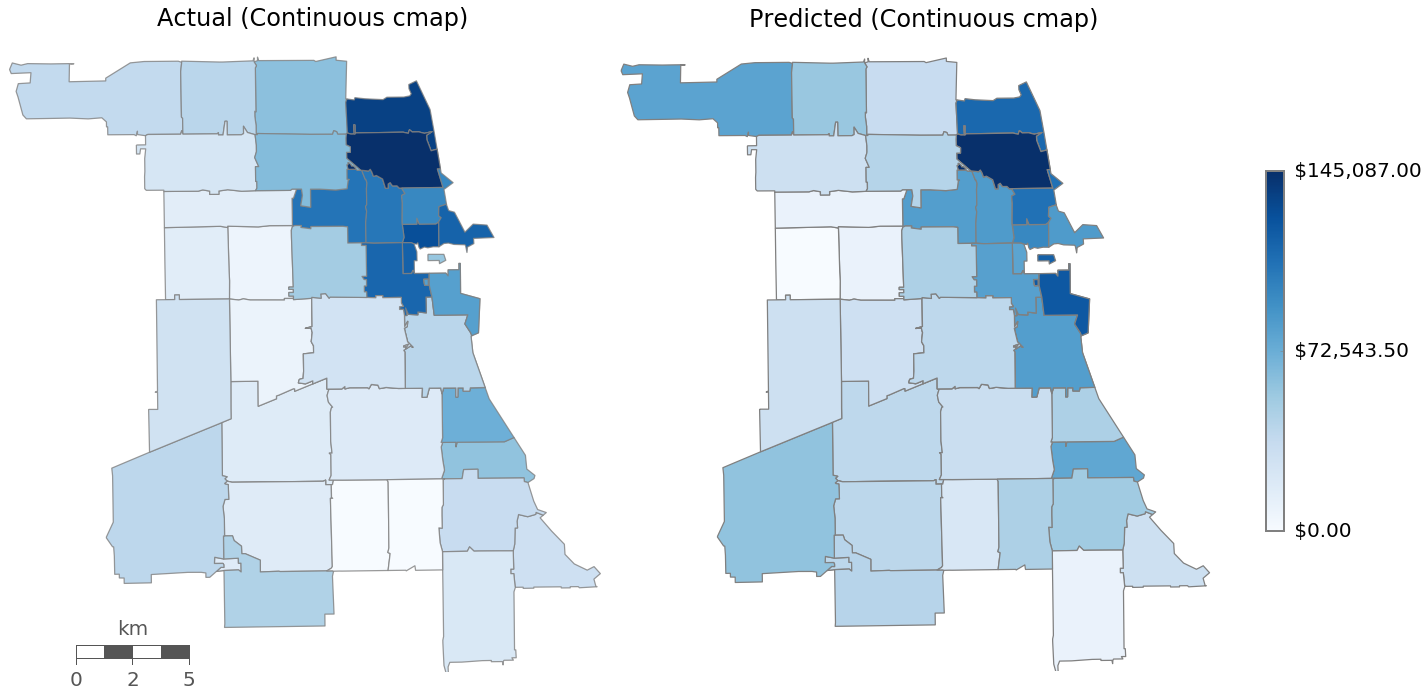